# Tutorial 3, Integration of simulated data

In [1]:
import sys
sys.path.append(r"/home/wangheqi/PycharmProject/")

import spcoral

from typing import Optional
import pandas as pd
import numpy as np
import scanpy as sc
import sklearn
import anndata
import torch
import matplotlib.pyplot as plt

### Read the data

The generation of the simulation data employed the method described in the article by [Townes et al.](https://doi.org/10.1038/s41592-022-01687-w).

The simulated data are divided into two types: those with the same resolution pair (adata_omics1 & adata_omics2) and those with different   resolution pair (adata_omics1 & adata_omics2_diff).

User can download this data from [google drive](https://drive.google.com/file/d/1LaYZa7pk9vgLdaW5PgIW4QB6NBhLxLuK/view?usp=sharing).

In [2]:
adata_omics1 = sc.read_h5ad('/home/wangheqi/PycharmProject/data/integtarion_sim/simdata_1/adata_sim_omics1_shuffled.h5ad')
adata_omics2 = sc.read_h5ad('/home/wangheqi/PycharmProject/data/integtarion_sim/simdata_1/adata_sim_omics2_shuffled.h5ad')
adata_omics2_diff = sc.read_h5ad('/home/wangheqi/PycharmProject/data/integtarion_sim/simdata_1/adata_sim_down_omics2_shuffled_annotation.h5ad')

### Show domains of the raw data

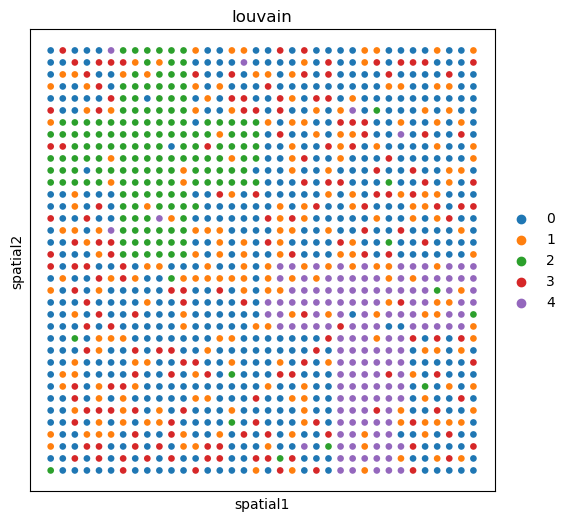

In [3]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(6, 6))
sc.pl.embedding(adata_omics1, basis='spatial', color='louvain', ax=ax)

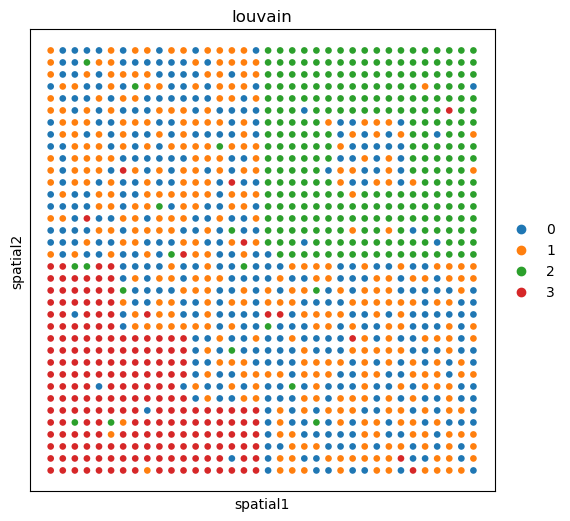

In [4]:
fig, ax = plt.subplots(figsize=(6, 6))
sc.pl.embedding(adata_omics2, basis='spatial', color='louvain', ax=ax)

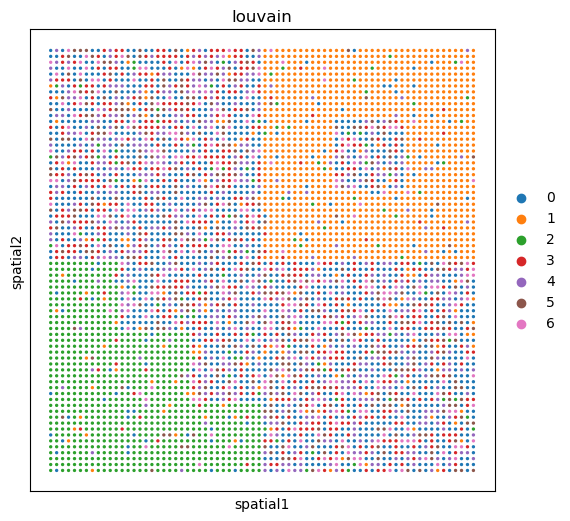

In [5]:
fig, ax = plt.subplots(figsize=(6, 6))
sc.pl.embedding(adata_omics2_diff, basis='spatial', color='louvain', ax=ax)

### Preprocess multi-omics data

In [6]:
sc.pp.scale(adata_omics1, max_value=5)
sc.pp.pca(adata_omics1, n_comps=50)
sc.pp.neighbors(adata_omics1)

In [7]:
sc.pp.scale(adata_omics2, max_value=5)
sc.pp.pca(adata_omics2, n_comps=30)
sc.pp.neighbors(adata_omics2, n_neighbors=30)

In [8]:
sc.pp.scale(adata_omics2_diff, max_value=5)
sc.pp.pca(adata_omics2_diff, n_comps=30)
sc.pp.neighbors(adata_omics2_diff, n_neighbors=50)

### Model training of the same resolution

In [9]:
adata_omics1.obsm['feat'] = adata_omics1.obsm['X_pca']
adata_omics2.obsm['feat'] = adata_omics2.obsm['X_pca']
adata_omics2_diff.obsm['feat'] = adata_omics2_diff.obsm['X_pca']

In [10]:
Model = spcoral.model.integrate_model(
    adata_omics1,
    adata_omics2,
    graph_method_single='radius',
    radius_spatial_omics1=0.2,
    radius_spatial_omics2=0.2,
    use_obsm='spatial',
    device=torch.device('cuda:0'),
    random_seed=2020
)

[Fast Mode] Seed=2020, cudnn.benchmark=True, multi-thread ON


In [11]:
adata_omics1, adata_omics2, loss_list = Model.train()
adata_omics1, adata_omics2 = spcoral.analysis.cluster(adata_omics1, adata_omics2, cluster_method='kmeans', cluster_number=5)

[Fast Mode] Seed=2020, cudnn.benchmark=True, multi-thread ON


Training: 100%|███████████████████████████████████████████████████████████████████████| 300/300 [03:52<00:00,  1.29it/s]


### Visualization of the same resolution

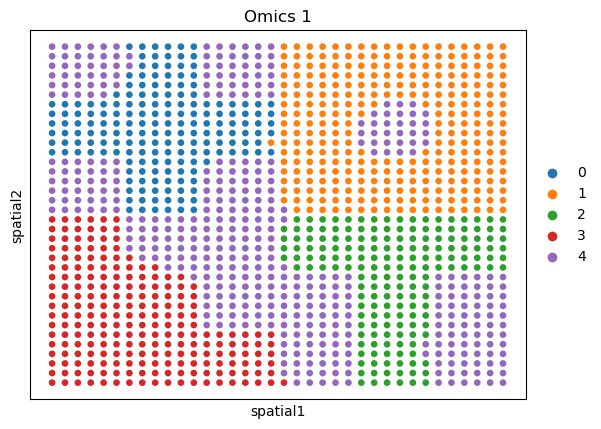

In [12]:
sc.pl.embedding(adata_omics1, basis='spatial', color='domain', title='Omics 1')

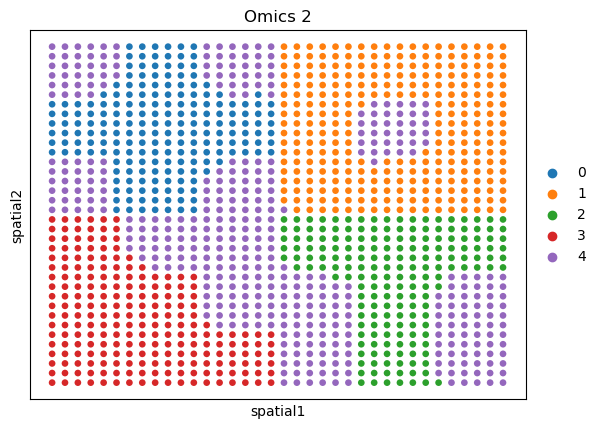

In [13]:
sc.pl.embedding(adata_omics2, basis='spatial', color='domain', title='Omics 2')

### Model training of the different resolutions

In [14]:
Model = spcoral.model.integrate_model(
    adata_omics1,
    adata_omics2_diff,
    graph_method_single='radius',
    radius_spatial_omics1=0.2,
    radius_spatial_omics2=0.2,
    use_obsm='spatial',
    device=torch.device('cuda:1'),
    random_seed=2020
)

[Fast Mode] Seed=2020, cudnn.benchmark=True, multi-thread ON


In [15]:
adata_omics1, adata_omics2_diff, loss_list = Model.train()
adata_omics1, adata_omics2_diff = spcoral.analysis.cluster(adata_omics1, adata_omics2_diff, cluster_method='kmeans', cluster_number=5)

[Fast Mode] Seed=2020, cudnn.benchmark=True, multi-thread ON


Training: 100%|███████████████████████████████████████████████████████████████████████| 300/300 [05:26<00:00,  1.09s/it]


### Visualization of the different resolutions

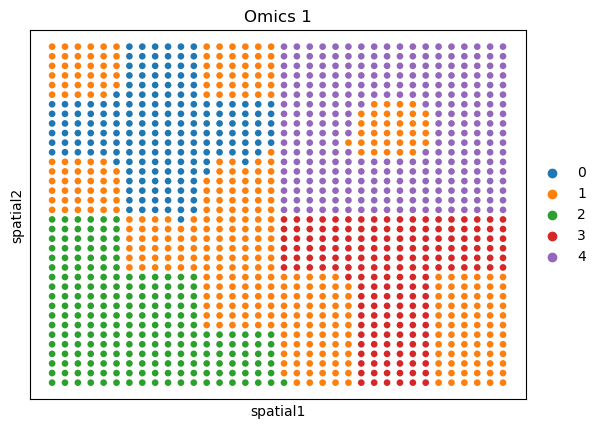

In [16]:
sc.pl.embedding(adata_omics1, basis='spatial', color='domain', title='Omics 1')

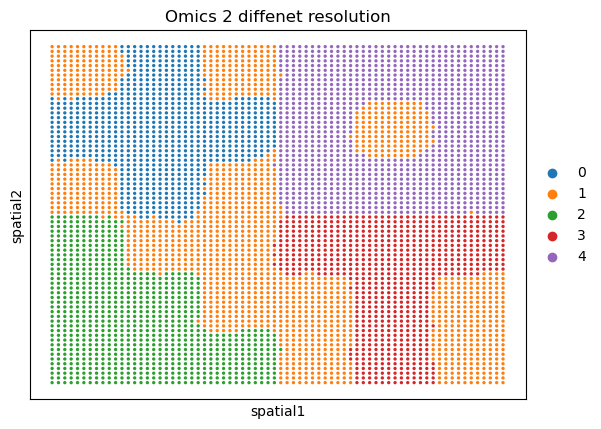

In [17]:
sc.pl.embedding(adata_omics2_diff, basis='spatial', color='domain', title='Omics 2 diffenet resolution')